In [1]:
#ИМПОРТИРУЕМ БИБЛИОТЕКИ

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from tensorflow.python.keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization

from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

2024-06-02 15:50:13.455448: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#ИМПОРТИРУЕМ ДАННЫЕ И СОЗДАЕМ ДАТАФРЕЙМЫ ДЛЯ УДОБНОЙ ИТЕРАЦИИ ПО ФАЙЛАМ

In [4]:
import os
import pandas as pd

train_dir = '/dataset/Train'
test_dir = '/dataset/Test'

train_df = pd.DataFrame(columns=['image_path', 'label'])
test_df = pd.DataFrame(columns=['image_path', 'label'])

for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_df = train_df._append({'image_path': image_path, 'label': label}, ignore_index=True)

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_df = test_df._append({'image_path': image_path, 'label': label}, ignore_index=True)
        
df = pd.concat([train_df, test_df], ignore_index=True)
del test_df,train_df

In [5]:
labels = os.listdir(train_dir)

label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'базально-клеточная карцинома',
 1: 'меланома',
 2: 'пигментный добр-ый кератоз',
 3: 'плоскоклеточный рак',
 4: 'родинка',
 5: 'себорейный кератоз',
 6: 'сосудистое поражение',
 7: 'старческий кератоз',
 8: 'фиброма кожи'}

In [6]:
#ПОСТРОИМ КРУГОВУЮ ДИАГРАММУ РАСПРЕДЕЛЕНИЯ ДАННЫХ ДЛЯ НАГЛЯДНОСТИ 

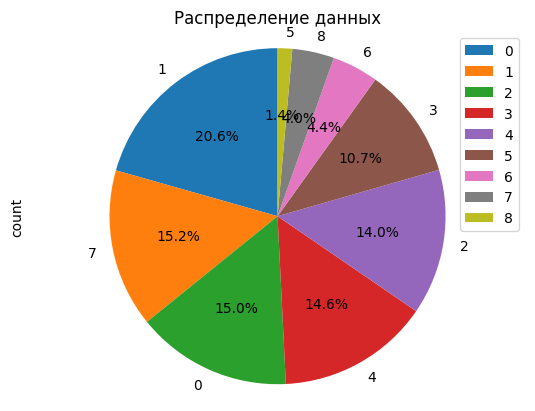

In [7]:
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Распределение данных')
plt.legend(df['label'].unique())
plt.show()

In [8]:
class_counts = df['label'].value_counts().sort_index()

print("Датасет")
print("-" * 60)
print(f"{'Номер класса':<15} {'Название класса':<30} {'Кол-во':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Датасет
------------------------------------------------------------
Номер класса    Название класса                Кол-во    
------------------------------------------------------------
0               базально-клеточная карцинома   852       
1               меланома                       1173      
2               пигментный добр-ый кератоз     798       
3               плоскоклеточный рак            607       
4               родинка                        834       
5               себорейный кератоз             80        
6               сосудистое поражение           253       
7               старческий кератоз             867       
8               фиброма кожи                   230       
------------------------------------------------------------
Total                                         5694      


In [9]:
#ПРЕДОБРАБОТАЕМ ИЗОБРАЖЕНИЯ

In [10]:
max_images_per_class = 4200

df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

/tmp/ipykernel_10420/2255022750.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [11]:
import tensorflow as tf #TODO: разобраться с видеокартой (!!!)

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-06-02 15:50:17.611619: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-02 15:50:17.615781: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-02 15:50:17.615820: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [12]:
import multiprocessing

max_workers = multiprocessing.cpu_count() - 2
max_workers

10

In [13]:
import concurrent.futures

def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

df['image'] = image_arrays
del image_arrays

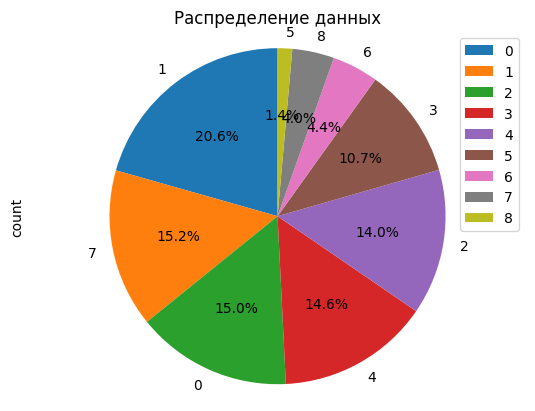

In [14]:
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Распределение данных')
plt.legend(df['label'].unique())
plt.show()

In [15]:
df.head()

,image_path,label,image
0,/dataset/Train/базально-клеточная карцинома/IS...,0,"[[[218, 202, 217], [213, 195, 218], [208, 178,..."
1,/dataset/Train/базально-клеточная карцинома/IS...,0,"[[[162, 118, 133], [168, 124, 134], [174, 129,..."
2,/dataset/Train/базально-клеточная карцинома/IS...,0,"[[[44, 27, 49], [58, 32, 55], [70, 41, 63], [8..."
3,/dataset/Train/базально-клеточная карцинома/IS...,0,"[[[212, 181, 188], [213, 179, 186], [208, 168,..."
4,/dataset/Train/базально-клеточная карцинома/IS...,0,"[[[194, 164, 178], [194, 161, 174], [197, 165,..."


In [16]:
#ОТОБРАЗИМ ИЗОБРАЖЕНИЯ И ИХ КОЛ-ВО ПЕРЕД АУГМЕНТАЦИЕЙ ДАННЫХ

In [17]:
class_counts = df['label'].value_counts().sort_index()

print("Датасет")
print("-" * 60)
print(f"{'Номер класса':<15} {'Название класса':<30} {'Кол-во':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Всего':<45} {sum(class_counts):<10}")

Датасет
------------------------------------------------------------
Номер класса    Название класса                Кол-во    
------------------------------------------------------------
0               базально-клеточная карцинома   852       
1               меланома                       1173      
2               пигментный добр-ый кератоз     798       
3               плоскоклеточный рак            607       
4               родинка                        834       
5               себорейный кератоз             80        
6               сосудистое поражение           253       
7               старческий кератоз             867       
8               фиброма кожи                   230       
------------------------------------------------------------
Всего                                         5694      


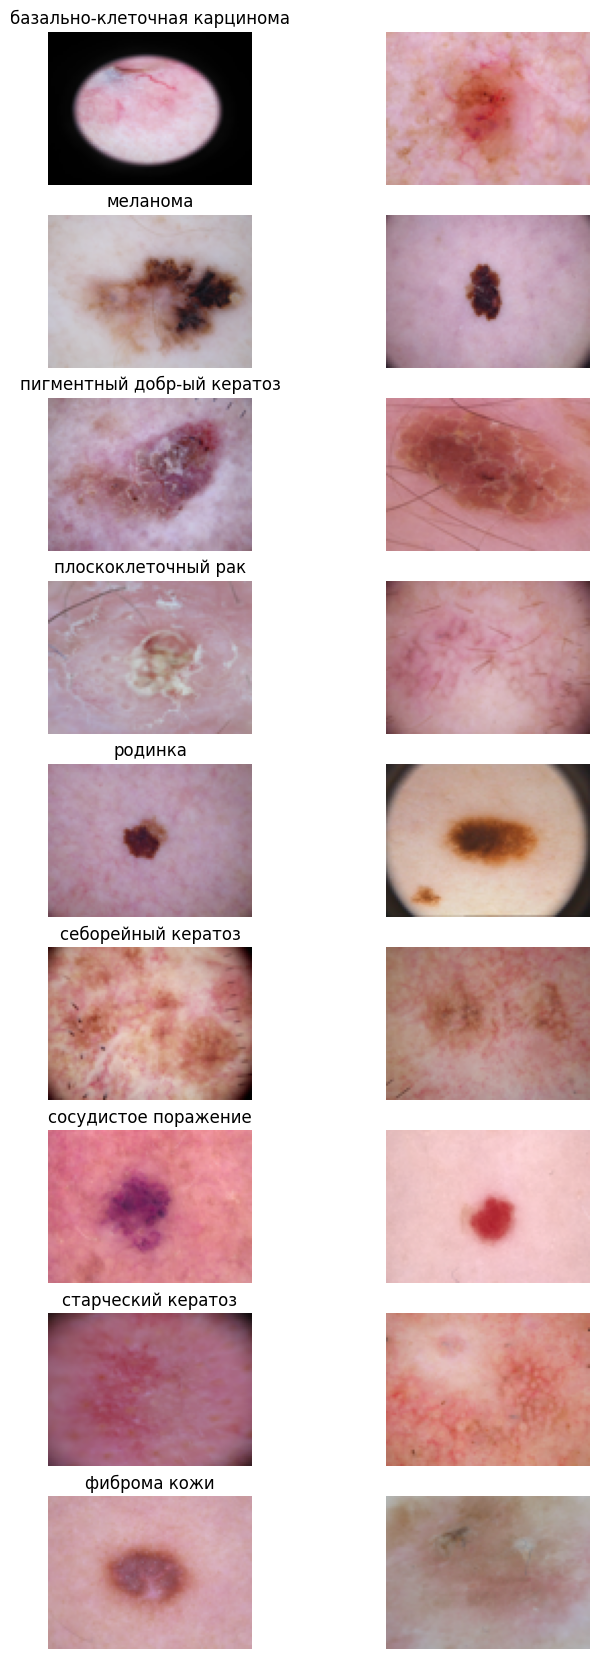

In [18]:
n_samples = 2
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [19]:
df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    5694
Name: count, dtype: int64

In [20]:
#АУГМЕНТАЦИЯ ДАННЫХ

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [22]:
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

for class_label in df['label'].unique():
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
    
    num_images_needed = max_images_per_class - len(image_arrays)
    
    if num_images_needed > 0:
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        
        for image_array in selected_images:
            image_tensor = np.expand_dims(image_array, axis=0)
            
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            augmented_image_array = augmented_images[0].astype('uint8')
            augmented_df = augmented_df._append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
    
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_df = augmented_df._append(original_images_df, ignore_index=True)

df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [23]:
class_counts = df['label'].value_counts().sort_index()

print("Датасет")
print("-" * 60)
print(f"{'Номер класса':<15} {'Название класса':<30} {'Кол-во':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Всего':<45} {sum(class_counts):<10}")

Датасет
------------------------------------------------------------
Номер класса    Название класса                Кол-во    
------------------------------------------------------------
0               базально-клеточная карцинома   4200      
1               меланома                       4200      
2               пигментный добр-ый кератоз     4200      
3               плоскоклеточный рак            4200      
4               родинка                        4200      
5               себорейный кератоз             4200      
6               сосудистое поражение           4200      
7               старческий кератоз             4200      
8               фиброма кожи                   4200      
------------------------------------------------------------
Всего                                         37800     


In [24]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [25]:
features.head()

,image
0,"[[[[169 148 158], [169 148 159], [168 150 164]..."
1,"[[[[161 133 145], [161 133 145], [161 133 145]..."
2,"[[[[231 179 161], [231 179 161], [231 179 161]..."
3,"[[[[229 199 215], [231 200 218], [232 200 218]..."
4,"[[[[129 107 92], [118 87 75], [107 75 70]..."


In [26]:
target.head()

0    2
1    8
2    0
3    8
4    5
Name: label, dtype: object

In [27]:
print(target.shape,features.shape)

(37800,) (37800, 1)


In [28]:
type(features)

pandas.core.frame.DataFrame

In [29]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

In [30]:
print(type(x_train), type(y_train))
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
(30240, 1) (30240,)
(7560, 1) (7560,)


In [31]:
x_train = np.asarray(x_train['image'].tolist(), dtype="object")
x_test = np.asarray(x_test['image'].tolist(), dtype="object")

In [32]:
y_train = np_utils.to_categorical(y_train,num_classes = num_classes)
y_test = np_utils.to_categorical(y_test,num_classes = num_classes)

In [33]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [34]:
x_train_reshaped = np.empty((len(x_train), 75, 100, 3))
for i in range(len(x_train)):
    x_train_reshaped[i] = x_train[i]
    
x_train = x_train_reshaped

x_test_reshaped = np.empty((len(x_test), 75, 100, 3))
for i in range(len(x_test)):
    x_test_reshaped[i] = x_test[i]
    
x_test = x_test_reshaped

x_validate_reshaped = np.empty((len(x_validate), 75, 100, 3))
for i in range(len(x_validate)):
    x_validate_reshaped[i] = x_validate[i]
    
x_validate = x_validate_reshaped

In [35]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [36]:
x_train.shape, y_train.shape

((24192, 75, 100, 3), (24192, 9))

In [37]:
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

print("Датасет")
print("-" * 90)
print(f"{'Номер класса':<15} {'Название класса':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Всего':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Всего':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Датасет
------------------------------------------------------------------------------------------
Номер класса    Название класса                Train      Validation   Test       Всего     
------------------------------------------------------------------------------------------
0               базально-клеточная карцинома   2702       677          821        4200      
1               меланома                       2703       690          807        4200      
2               пигментный добр-ый кератоз     2679       670          851        4200      
3               плоскоклеточный рак            2626       697          877        4200      
4               родинка                        2692       666          842        4200      
5               себорейный кератоз             2651       669          880        4200      
6               сосудистое поражение           2693       668          839        4200      
7               старческий кератоз             2746       641     

In [38]:
df.groupby('label').size()

label
0    4200
1    4200
2    4200
3    4200
4    4200
5    4200
6    4200
7    4200
8    4200
dtype: int64

In [39]:
input_shape = df['image'][0].shape
input_shape

(1, 75, 100, 3)

In [40]:
input_shape = (75,100,3)

In [41]:
#АРХИТЕКТУРА

In [42]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

# DenseNet201
model = Sequential()
model.add(DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(2048, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(512, activation='silu'))
model.add(Dropout(0.05))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

2024-06-02 15:52:03.314097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-02 15:52:03.314496: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-02 15:52:03.314518: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-02 15:52:03.826834: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-02 15:52:03.826891: I external/local_xla/xla/stream_executor

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ ?                      │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 18,092,928 (69.02 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [43]:
#ОПТИМИЗАТОР

In [44]:
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [45]:
#ОБУЧЕНИЕ УРА!!!!

In [46]:
import time
start = time.time()

epochs = 40
batch_size = 64

history = model.fit(x=x_train, y=y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)

end = time.time()
print(f"Training time: {(end - start)/60:.4f} (mins)")

2024-06-02 15:52:30.135540: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2177280000 exceeds 10% of free system memory.
2024-06-02 15:52:43.740507: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2177280000 exceeds 10% of free system memory.


Epoch 1/40


2024-06-02 15:53:08.947801: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 94371840 exceeds 10% of free system memory.
2024-06-02 15:53:09.015505: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 94371840 exceeds 10% of free system memory.
2024-06-02 15:53:09.174287: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 94371840 exceeds 10% of free system memory.
I0000 00:00:1717343607.630679   10519 service.cc:145] XLA service 0x7fc4740065f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717343607.630805   10519 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-06-02 15:53:29.180410: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-02 15:53:32.215851: I external/local_xla/xla/stream_executor/cu

378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.1360 - loss: 2.1934

I0000 00:00:1717343766.183187   10703 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5428', 252 bytes spill stores, 252 bytes spill loads

I0000 00:00:1717343767.073721   10701 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5423', 252 bytes spill stores, 252 bytes spill loads

I0000 00:00:1717343776.878548   10768 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5423', 252 bytes spill stores, 252 bytes spill loads

I0000 00:00:1717343777.476489   10769 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5428', 252 bytes spill stores, 252 bytes spill loads



378/378 ━━━━━━━━━━━━━━━━━━━━ 225s 183ms/step - accuracy: 0.1362 - loss: 2.1932 - val_accuracy: 0.2935 - val_loss: 1.9046 - learning_rate: 0.0010
Epoch 2/40
378/378 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.3606 - loss: 1.7459 - val_accuracy: 0.4205 - val_loss: 1.5224 - learning_rate: 0.0010
Epoch 3/40
378/378 ━━━━━━━━━━━━━━━━━━━━ 37s 97ms/step - accuracy: 0.5805 - loss: 1.1279 - val_accuracy: 0.6224 - val_loss: 0.9622 - learning_rate: 0.0010
Epoch 4/40
378/378 ━━━━━━━━━━━━━━━━━━━━ 37s 98ms/step - accuracy: 0.7035 - loss: 0.7911 - val_accuracy: 0.6989 - val_loss: 0.8230 - learning_rate: 0.0010
Epoch 5/40
378/378 ━━━━━━━━━━━━━━━━━━━━ 37s 98ms/step - accuracy: 0.7878 - loss: 0.5741 - val_accuracy: 0.7133 - val_loss: 0.7993 - learning_rate: 0.0010
Epoch 6/40
378/378 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - accuracy: 0.8572 - loss: 0.3972 - val_accuracy: 0.7219 - val_loss: 0.8494 - learning_rate: 0.0010
Epoch 7/40
378/378 ━━━━━━━━━━━━━━━━━━━━ 37s 98ms/step - accuracy: 0.9095 - loss: 0.2

In [47]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

756/756 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.9972 - loss: 0.0043
Train: accuracy = 0.997313  ;  loss = 0.004123


In [48]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

235/237 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9199 - loss: 0.3718

I0000 00:00:1717345398.428832   13198 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5422', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1717345398.998748   13190 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5427', 20 bytes spill stores, 20 bytes spill loads



237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9199 - loss: 0.3720
Testing: accuracy = 0.919180  ;  loss = 0.390624


237/237 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step


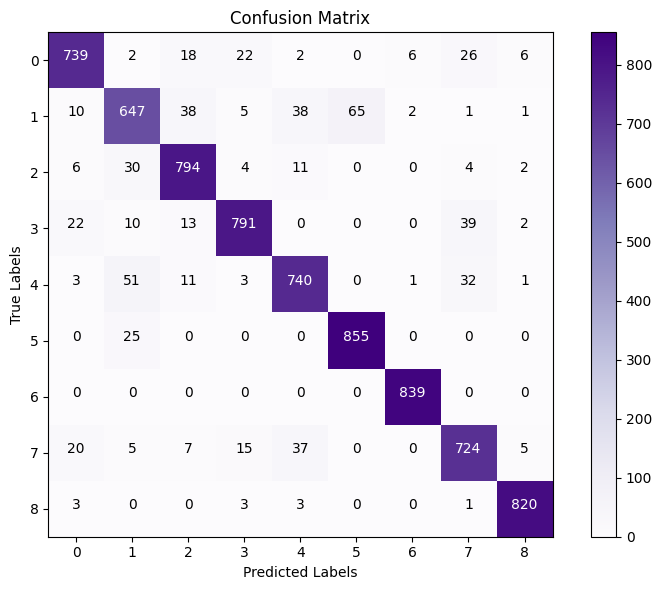

In [49]:
from sklearn.metrics import confusion_matrix

y_pred_prob = model.predict(x_test)

y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
plt.title('Confusion Matrix')
plt.colorbar()

# Добавление меток к осям
tick_marks = np.arange(len(np.unique(np.argmax(y_test, axis=1))))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# Подписи к ячейкам
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()
plt.show()

In [50]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy(точность): {accuracy:.4f}")
print(f"Precision(точность): {precision:.4f}")
print(f"Recall(полнота): {recall:.4f}")
print(f"F1-score(F-мера): {f1:.4f}")
print(f"Kappa score(Коэф-т Каппы): {kappa:.4f}")

Accuracy(точность): 0.9192
Precision(точность): 0.9183
Recall(полнота): 0.9184
F1-score(F-мера): 0.9181
Kappa score(Коэф-т Каппы): 0.9091


In [51]:
label_map

{0: 'базально-клеточная карцинома',
 1: 'меланома',
 2: 'пигментный добр-ый кератоз',
 3: 'плоскоклеточный рак',
 4: 'родинка',
 5: 'себорейный кератоз',
 6: 'сосудистое поражение',
 7: 'старческий кератоз',
 8: 'фиброма кожи'}

In [52]:
model.save_weights('4200(92acc).weights.h5')

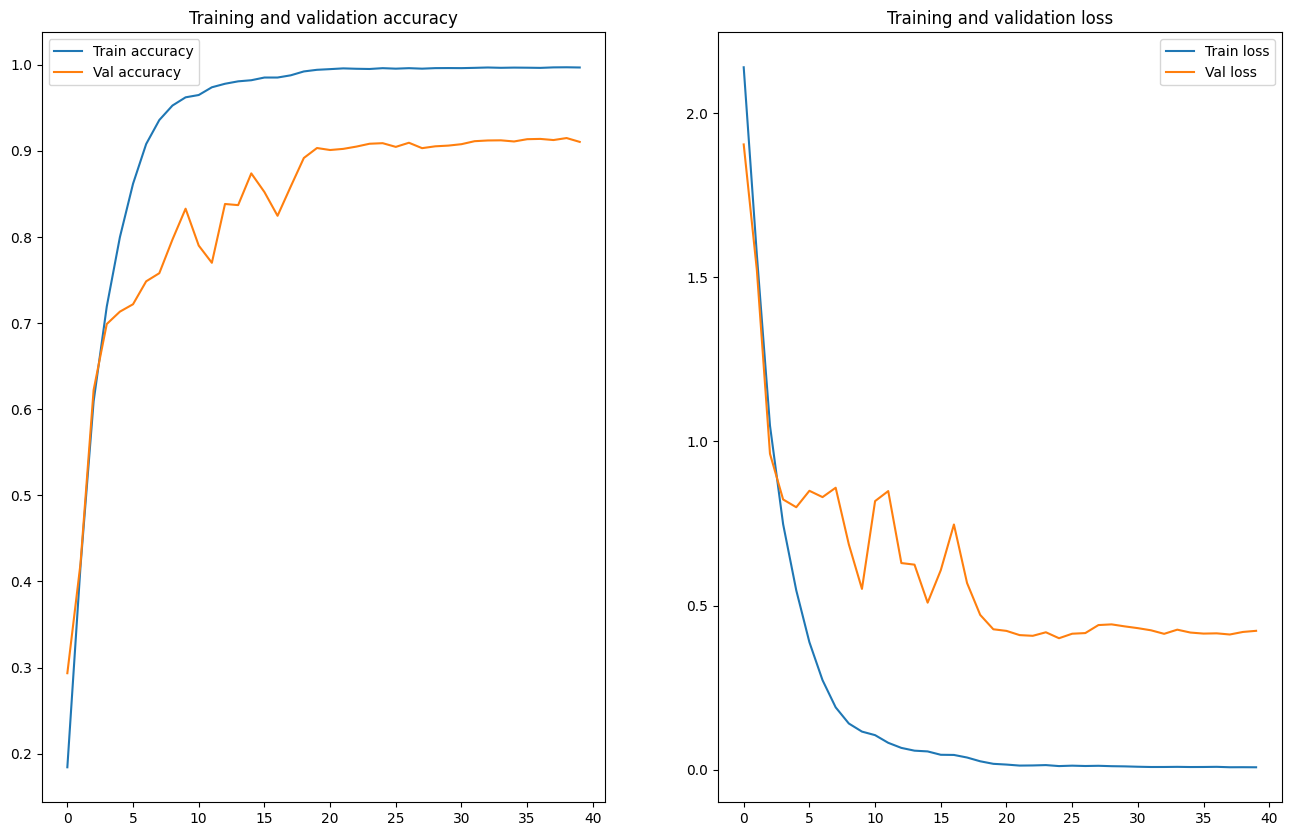

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train accuracy')
plt.plot(epochs, val_acc, label='Val accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train loss')
plt.plot(epochs, val_loss, label='Val loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.show()